In [1]:
import numpy as np
from numpy import savetxt
from numpy import loadtxt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import pickle 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable
import corner

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sys, platform, os
from numpy import sqrt, sin, cos, pi
import scipy.constants as cst

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
tf.__version__

'2.8.0'

In [2]:
import scipy.integrate as integrate
import scipy.special as special     
from scipy.interpolate import CubicSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

In [3]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.66, ombh2=0.02242, omch2=0.11933)
pars.InitPower.set_params(As=2.105209331e-9, ns=0.9665)
pars.set_matter_power(redshifts=[0.0], kmax=15.0)
pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

# Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
camb_kh1, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
s8_current = np.array(results.get_sigma8())
s8_fid = np.array([0.8102])
renorm_s8 = (s8_fid/s8_current)**2
camb_pk1 = renorm_s8*camb_pk_cur

In [5]:
print(camb_kh1[338])
print(camb_pk1[0][288])
print(camb_kh1[-1])
print(len(camb_kh1))

0.32066369357971425
5711.586793560739
14.999999999999995
500


In [13]:
%%time 
#k1: FIXED

bispectrum = []
counter = 0
K1 = []
K2 = []
K3 = []

k1 = camb_kh1[338]               #K1 = 0.32066369357971425
K1.append(k1)


for j in range(338, len(camb_kh1)):
    k2 = camb_kh1[j]
    for m in range(j, len(camb_kh1)):
        k3 = camb_kh1[m]

        if np.abs(k3) <= np.abs(k1) + np.abs(k2):                                        # Triangle inequality

            K2.append(k2)
            K3.append(k3)

            c_theta12 = (k1**2 + k2**2 - k3**2)/2*k1*k2
            c_theta23 = (k2**2 + k3**2 - k1**2)/2*k2*k3
            c_theta31 = (k3**2 + k1**2 - k2**2)/2*k3*k1

            k12_dot = np.abs(k1*k2)*c_theta12
            k23_dot = np.abs(k2*k3)*c_theta23
            k31_dot = np.abs(k3*k1)*c_theta31

            bp = (10/7 + (k12_dot/k1*k2)*(k1/k2 + k2/k1) + 4/7*(k12_dot/k1*k2)**2)*camb_pk1[0][338]*camb_pk1[0][j] \
            + (10/7 + (k23_dot/k2*k3)*(k2/k3 + k3/k2) + 4/7*(k23_dot/k2*k3)**2)*camb_pk1[0][j]*camb_pk1[0][m] \
            + (10/7 + (k31_dot/k3*k1)*(k3/k1 + k1/k3) + 4/7*(k31_dot/k3*k1)**2)*camb_pk1[0][m]*camb_pk1[0][338]

            bispectrum.append(bp)
            #print('bispectrum:', bp)

            counter += 1
                
print('counter:', counter)
print('bispectrum shape:', np.shape(bispectrum))
print('K1:', np.shape(K1))
print('K2:', np.shape(K2))
print('K3:', np.shape(K3))

counter: 1504
bispectrum shape: (1504,)
K1: (1,)
K2: (1504,)
K3: (1504,)
Wall time: 77.8 ms


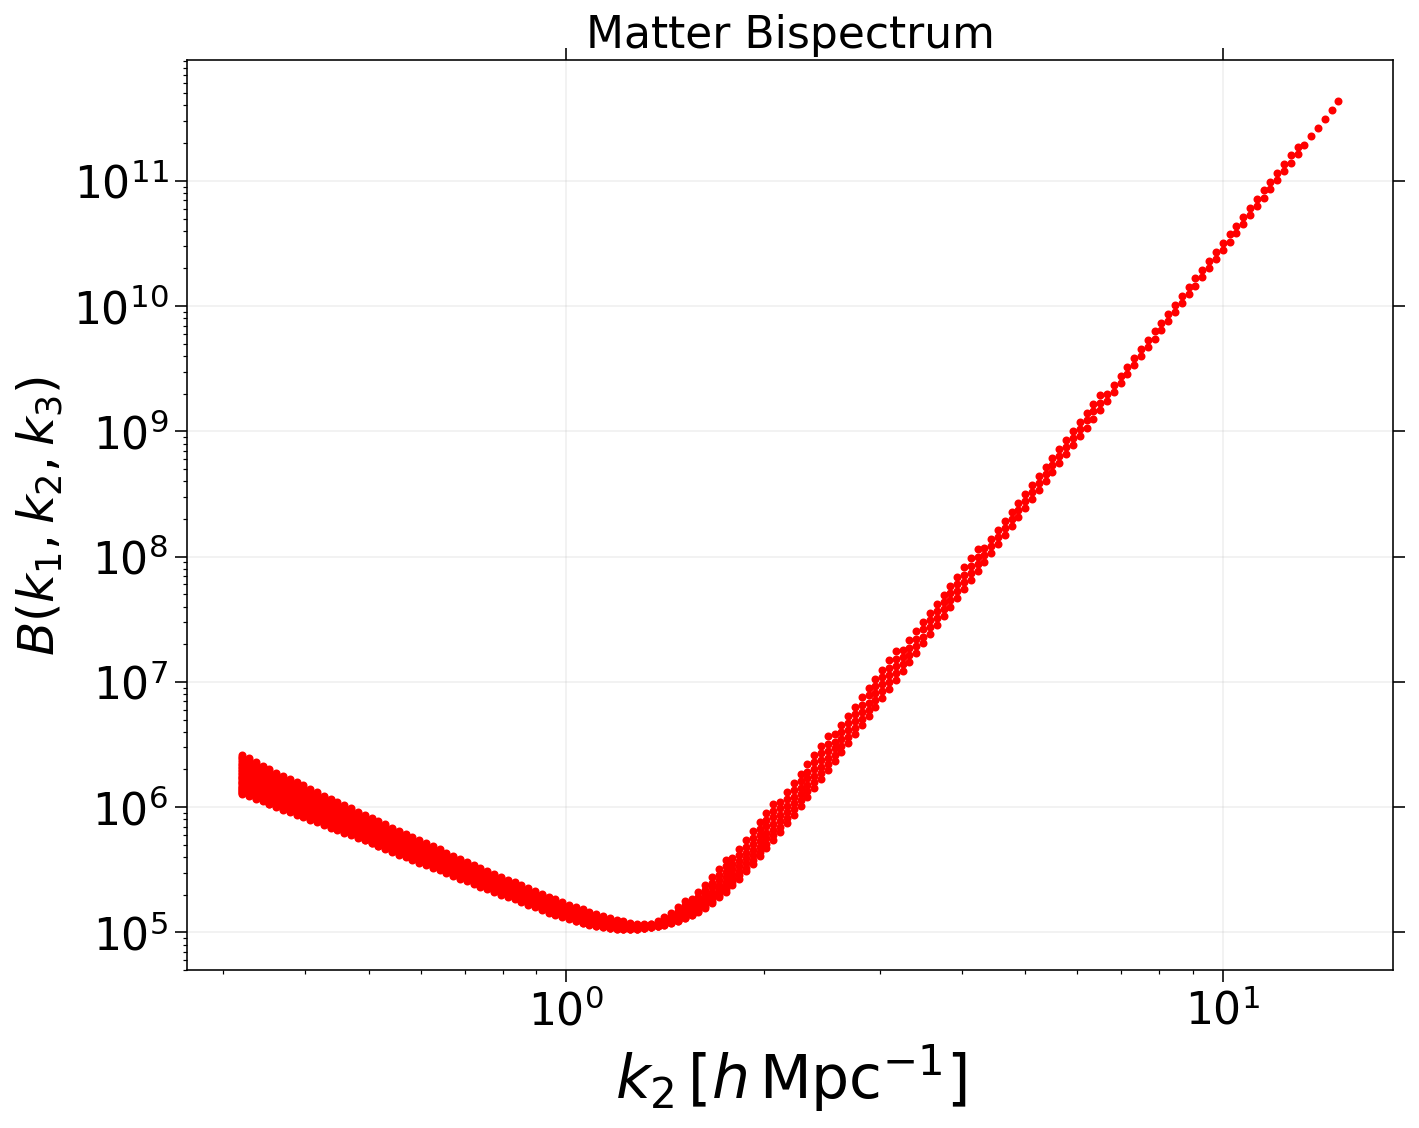

In [16]:
plt.figure(figsize = (10,8))
#plt.loglog(K1, bispectrum, 'b.') 
plt.loglog(K2, bispectrum, 'r.')
#plt.loglog(K3, bispectrum, 'g.') 
#plt.yscale('linear')

plt.title('Matter Bispectrum', fontsize = 22)
plt.rc('axes', labelsize=22)
plt.rc('axes', titlesize=22)
plt.rcParams['xtick.labelsize']=22
plt.rcParams['ytick.labelsize']=22
plt.xlabel(r'$k_{2}\,[h\,\mathrm{Mpc}^{-1}]$', fontsize=30)
plt.ylabel(r'$B(k_{1},k_{2},k_{3})$', fontsize=25)
#plt.legend(["Linear", "Non-linear"], loc='upper right', fontsize=22);
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)

plt.tight_layout()
#plt.savefig('NLMPS_1dim_H0_MaxPE_comb.pdf')
plt.show()

In [17]:
print(camb_kh1[315])
print(camb_kh1[288])
print(camb_kh1[338])
print(camb_pk1[0][288])
print(camb_kh1[-1])
print(len(camb_kh1))

0.18512814013775777
0.09714117939590412
0.32066369357971425
5711.586793560739
14.999999999999995
500


In [18]:
%%time 
#k1: FIXED v2

bispectrum = []
counter = 0
K1 = []
K2 = []
K3 = []

k1 = camb_kh1[338]   #0.320
K1.append(k1)

#k2_range = (0.18512814013775777, 0.320)
#k3_range = (0.09714117939590412, 0.320)

for j in range(315, 338):
    k2 = camb_kh1[j]
    for m in range(288, 338):
        k3 = camb_kh1[m]

        if np.abs(k3) <= np.abs(k1) + np.abs(k2):                                        # Triangle inequality

            K2.append(k2)
            K3.append(k3)

            c_theta12 = (k1**2 + k2**2 - k3**2)/2*k1*k2
            c_theta23 = (k2**2 + k3**2 - k1**2)/2*k2*k3
            c_theta31 = (k3**2 + k1**2 - k2**2)/2*k3*k1

            k12_dot = np.abs(k1*k2)*c_theta12
            k23_dot = np.abs(k2*k3)*c_theta23
            k31_dot = np.abs(k3*k1)*c_theta31

            bp = (10/7 + (k12_dot/k1*k2)*(k1/k2 + k2/k1) + 4/7*(k12_dot/k1*k2)**2)*camb_pk1[0][338]*camb_pk1[0][j] \
            + (10/7 + (k23_dot/k2*k3)*(k2/k3 + k3/k2) + 4/7*(k23_dot/k2*k3)**2)*camb_pk1[0][j]*camb_pk1[0][m] \
            + (10/7 + (k31_dot/k3*k1)*(k3/k1 + k1/k3) + 4/7*(k31_dot/k3*k1)**2)*camb_pk1[0][m]*camb_pk1[0][338]

            bispectrum.append(bp)
            #print('bispectrum:', bp)

            counter += 1
                
print('counter:', counter)
print('bispectrum shape:', np.shape(bispectrum))
print('K1:', np.shape(K1))
print('K2:', np.shape(K2))
print('K3:', np.shape(K3))

counter: 1150
bispectrum shape: (1150,)
K1: (1,)
K2: (1150,)
K3: (1150,)
Wall time: 33.9 ms


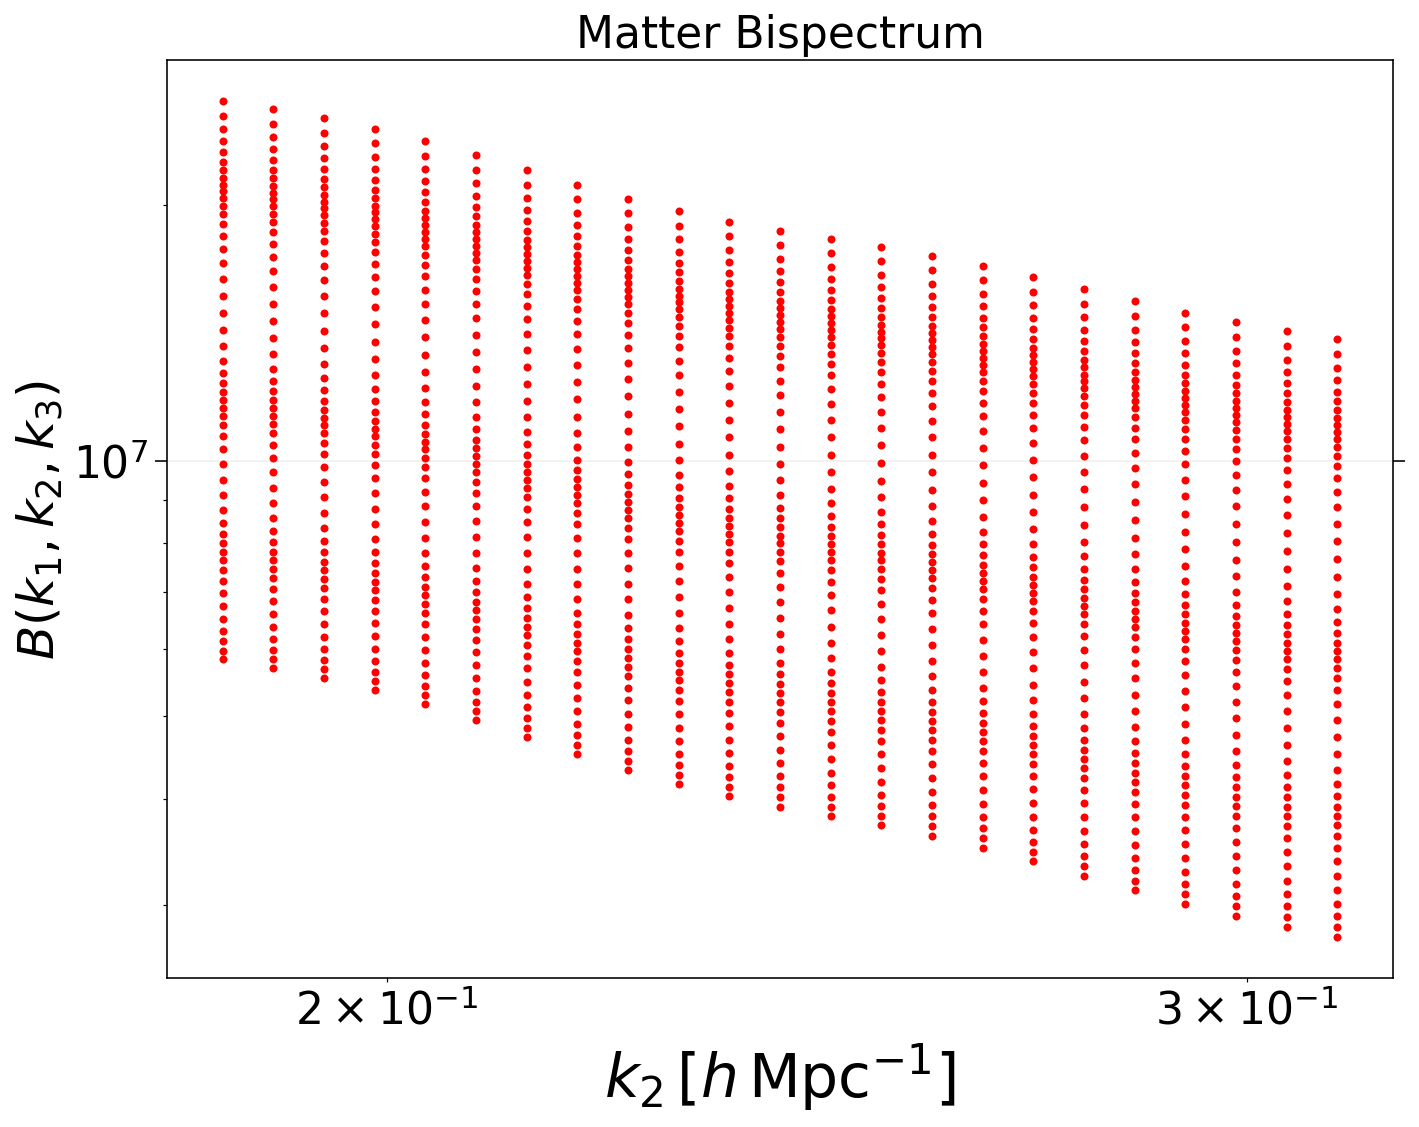

In [19]:
plt.figure(figsize = (10,8))
#plt.loglog(K1, bispectrum, 'b.') 
plt.loglog(K2, bispectrum, 'r.')
#plt.loglog(K3, bispectrum, 'g') 
#plt.yscale('linear')

plt.title('Matter Bispectrum', fontsize = 22)
plt.rc('axes', labelsize=22)
plt.rc('axes', titlesize=22)
plt.rcParams['xtick.labelsize']=22
plt.rcParams['ytick.labelsize']=22
plt.xlabel(r'$k_{2}\,[h\,\mathrm{Mpc}^{-1}]$', fontsize=30)
plt.ylabel(r'$B(k_{1},k_{2},k_{3})$', fontsize=25)
#plt.legend(["Linear", "Non-linear"], loc='upper right', fontsize=22);
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)

plt.tight_layout()
#plt.savefig('NLMPS_1dim_H0_MaxPE_comb.pdf')
plt.show()

In [20]:
print(camb_kh1[300])
print(camb_kh1[350])
print(camb_kh1[338])
print(camb_pk1[0][288])
print(camb_kh1[-1])
print(len(camb_kh1))

0.12938338596873525
0.42709543666847616
0.32066369357971425
5711.586793560739
14.999999999999995
500


In [22]:
%%time 
#k1 & k2: FIXED

bispectrum = []
counter = 0
K1 = []
K2 = []
K3 = []

k1 = camb_kh1[300]    #0.12938338596873525
K1.append(k1)
k2 = camb_kh1[350]    #0.42709543666847616
K2.append(k2)


for m in range(0, len(camb_kh1)):
    k3 = camb_kh1[m]

    if np.abs(k3) <= np.abs(k1) + np.abs(k2):                                        # Triangle inequality

        K3.append(k3)

        c_theta12 = (k1**2 + k2**2 - k3**2)/2*k1*k2
        c_theta23 = (k2**2 + k3**2 - k1**2)/2*k2*k3
        c_theta31 = (k3**2 + k1**2 - k2**2)/2*k3*k1

        k12_dot = np.abs(k1*k2)*c_theta12
        k23_dot = np.abs(k2*k3)*c_theta23
        k31_dot = np.abs(k3*k1)*c_theta31

        bp = (10/7 + (k12_dot/k1*k2)*(k1/k2 + k2/k1) + 4/7*(k12_dot/k1*k2)**2)*camb_pk1[0][300]*camb_pk1[0][350] \
        + (10/7 + (k23_dot/k2*k3)*(k2/k3 + k3/k2) + 4/7*(k23_dot/k2*k3)**2)*camb_pk1[0][350]*camb_pk1[0][m] \
        + (10/7 + (k31_dot/k3*k1)*(k3/k1 + k1/k3) + 4/7*(k31_dot/k3*k1)**2)*camb_pk1[0][m]*camb_pk1[0][300]

        bispectrum.append(bp)
        #print('bispectrum:', bp)

        counter += 1
                
print('counter:', counter)
print('bispectrum shape:', np.shape(bispectrum))
print('K1:', np.shape(K1))
print('K2:', np.shape(K2))
print('K3:', np.shape(K3))

counter: 362
bispectrum shape: (362,)
K1: (1,)
K2: (1,)
K3: (362,)
Wall time: 9.94 ms


In [23]:
print(bispectrum[4])
print(bispectrum[5])
print(bispectrum[6])
print(bispectrum[7])
print(bispectrum[8])
print(bispectrum[9])
print(bispectrum[10])
print(bispectrum[-1])

5515870.821827393
5585921.089127805
5657604.0486505255
5730957.607878627
5806020.55116401
5882832.557537615
5961434.214852001
4105061.256752724


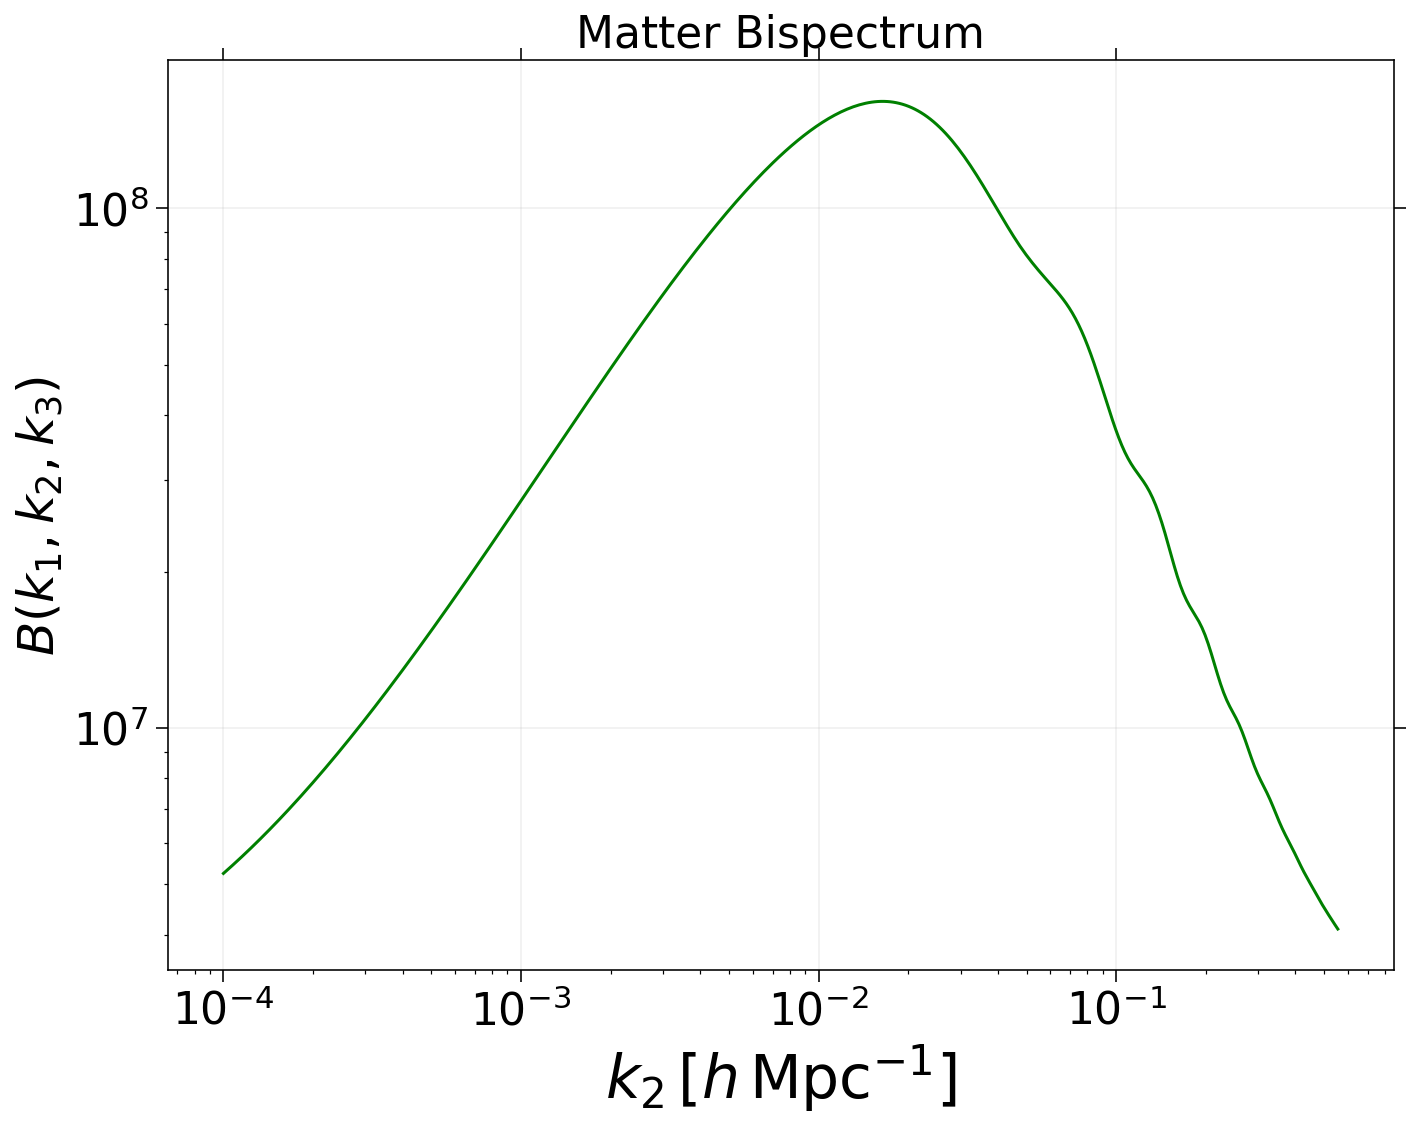

In [27]:
plt.figure(figsize = (10,8))
#plt.loglog(K1, bispectrum, 'b.') 
#plt.loglog(K2, bispectrum, 'r.')
plt.loglog(K3, bispectrum, 'g') 
#plt.yscale('linear')

plt.title('Matter Bispectrum', fontsize = 22)
plt.rc('axes', labelsize=22)
plt.rc('axes', titlesize=22)
plt.rcParams['xtick.labelsize']=22
plt.rcParams['ytick.labelsize']=22
plt.xlabel(r'$k_{2}\,[h\,\mathrm{Mpc}^{-1}]$', fontsize=30)
plt.ylabel(r'$B(k_{1},k_{2},k_{3})$', fontsize=25)
#plt.legend(["Linear", "Non-linear"], loc='upper right', fontsize=22);
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)

plt.tight_layout()
#plt.savefig('NLMPS_1dim_H0_MaxPE_comb.pdf')
plt.show()

%%time 
bispectrum = []
counter = 0
K1 = []
K2 = []
K3 = []

for i in range(0, len(camb_kh1)):
    k1 = camb_kh1[i]
    for j in range(i, len(camb_kh1)):
        k2 = camb_kh1[j]
        for m in range(j, len(camb_kh1)):
            k3 = camb_kh1[m]

            if np.abs(k3) <= np.abs(k1) + np.abs(k2):                                        # Triangle inequality
                
                K1.append(k1)
                K2.append(k2)
                K3.append(k3)
                
                c_theta12 = (k1**2 + k2**2 - k3**2)/2*k1*k2
                c_theta23 = (k2**2 + k3**2 - k1**2)/2*k2*k3
                c_theta31 = (k3**2 + k1**2 - k2**2)/2*k3*k1
            
                k12_dot = np.abs(k1*k2)*c_theta12
                k23_dot = np.abs(k2*k3)*c_theta23
                k31_dot = np.abs(k3*k1)*c_theta31
            
                bp = (10/7 + (k12_dot/k1*k2)*(k1/k2 + k2/k1) + 4/7*(k12_dot/k1*k2)**2)*camb_pk1[0][i]*camb_pk1[0][j] \
                + (10/7 + (k23_dot/k2*k3)*(k2/k3 + k3/k2) + 4/7*(k23_dot/k2*k3)**2)*camb_pk1[0][j]*camb_pk1[0][m] \
                + (10/7 + (k31_dot/k3*k1)*(k3/k1 + k1/k3) + 4/7*(k31_dot/k3*k1)**2)*camb_pk1[0][m]*camb_pk1[0][i]

                bispectrum.append(bp)
                #print('bispectrum:', bp)
                
                counter += 1
                
print('counter:', counter)
print('bispectrum shape:', np.shape(bispectrum))
print('K1:', np.shape(K1))
print('K2:', np.shape(K2))
print('K3:', np.shape(K3))

In [ ]:
def bispectrum(k1, k2, k3):

    return (10/7 + (np.dot(k1,k2)/k1*k2)*(k1/k2 + k2/k1) + 4/7*(np.dot(k1,k2)/k1*k2)**2)*camb_pk1*camb_pk2 \
         + (10/7 + (np.dot(k2,k3)/k2*k3)*(k2/k3 + k3/k2) + 4/7*(np.dot(k2,k3)/k2*k3)**2)*camb_pk2*camb_pk3 \
         + (10/7 + (np.dot(k3,k1)/k3*k1)*(k3/k1 + k1/k3) + 4/7*(np.dot(k3,k1)/k3*k1)**2)*camb_pk3*camb_pk1